### Cts-Genome Coverage Plots

In [10]:
import pandas as pd
from datetime import datetime

In [11]:
dt = datetime.today().strftime(format='%d-%m-%Y')

In [2]:
home_dir = '/home/douso/SarsGenomics/Processed'
df_cov = pd.read_excel(f'{home_dir}/metadata-seq-MS-Merge@KB8.xlsx', usecols=['S_NUM', 'G_COV'])

In [3]:
df_cov

,S_NUM,G_COV
0,COVC00854,94.8
1,COVC00867,66.7
2,COVC00893,82.6
3,COVC00915,NaN
4,COVC00962,93.3
...,...,...
1065,COVC24209,91.8
1066,COVC24214,96.7
1067,COVC24215,90.1
1068,COVC24216,94.6


In [4]:
samp_names = list(df_cov['S_NUM'])

In [5]:
df_Cts = pd.read_excel('/home/douso/Documents/RunSheets/Cts/runsheet-cts.xlsx')[['Sample_Name', 'Ct_Mean']]
# df_nhrl_Cts = pd.read_excel('/home/douso/Documents/RunSheets/Cts/NHRL-cts.xlsx')
# df_Cts = df_covc_Cts.append(df_nhrl_Cts)

In [6]:
df_ct_cov = (df_Cts.merge(df_cov, how='inner', left_on='Sample_Name', 
            right_on='S_NUM').drop('S_NUM',axis=1).sort_values('Ct_Mean').dropna())#[df_Cts['Sample_Name'].isin(samp_names)]

In [7]:
# df_ct_cov.to_excel('/home/douso/Documents/RunSheets/Cts/cts-cov.xlsx', index=False, float_format='%.0f')

In [93]:
mask1 = df_ct_cov['G_COV'] >= 80
mask2 = df_ct_cov['Ct_Mean'] >= 30
mask3 = df_ct_cov['Ct_Mean'] <= 35
mask4 = df_ct_cov['G_COV'] <= 80
mask5 = df_ct_cov['G_COV'] > 80
mask6 = df_ct_cov['G_COV'] < 80
mask7 = df_ct_cov['Ct_Mean'] < 30

above30below35_pass = df_ct_cov[mask1 & mask2 & mask3 == True].shape[0]
above30below35_fail = df_ct_cov[mask4 & mask2 & mask3 == True].shape[0]
below30above80_pass = df_ct_cov[mask5 & mask7 == True].shape[0]
below30below80_fail = df_ct_cov[mask6 & mask7 == True].shape[0]
print(below30above80_pass, below30below80_fail)

430 108


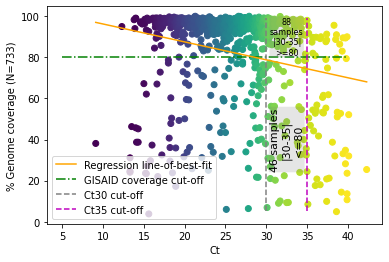

In [89]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

fig,ax = plt.subplots()
lr = LinearRegression()
lr.fit(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1), df_ct_cov['G_COV'])

y_predicted = lr.predict(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1))

plt.plot(df_ct_cov['Ct_Mean'], y_predicted, color='orange', label='Regression line-of-best-fit')

plt.scatter(df_ct_cov['Ct_Mean'], df_ct_cov['G_COV'], 
            c=np.linspace(0, 40, len(df_ct_cov['Ct_Mean'])), 
            cmap='viridis')#viridis#RdYlBu ,edgecolors='#FFF5EE'
# plt.colorbar(label='Cts', location='bottom')
ax.text(32.5, 90, s=f'{above30below35_pass}\nsamples\n|30-35|\n>=80', 
        ha="center", va="center", rotation=0, fontsize=8, 
        bbox=dict(boxstyle="round,pad=0.05", fc="gray", alpha=0.2, ec="b", lw=0))
ax.text(32.5, 40, s=f'{above30below35_fail} samples\n|30-35|\n<=80', 
        ha="center", va="center", rotation=90, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.1", fc="gray", alpha=0.2, ec="b", lw=0))
plt.xlabel('Ct')
plt.ylabel(f'% Genome coverage (N={len(df_ct_cov["Ct_Mean"])})')
plt.hlines(80, 5, 40, linestyles='dashdot', colors='g', label='GISAID coverage cut-off')
plt.vlines(30, 5, 99, linestyles='dashed', colors='gray', label='Ct30 cut-off')
plt.vlines(35, 5, 99, linestyles='dashed', colors='m', label='Ct35 cut-off')
plt.legend()
fig.savefig(f'/home/douso/SarsGenomics/Processed/cts-trend_{dt}.png')
plt.show()

In [91]:
df_ct_cov[mask4 & mask2 & mask3 == True].sort_values('G_COV')

,Sample_Name,Ct_Mean,G_COV
303,COVC19546,30.1,6.9
312,COVC19687,31.5,9.0
440,COVC21291,32.5,9.3
468,COVC22144,32.7,9.4
314,COVC19619,31.7,10.1
52,COVC01972,31.1,20.2
264,COVC18908,30.5,21.0
521,COVC23171,32.2,22.4
509,COVC22966,34.1,24.0
308,COVC19635,35.0,24.4
